In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [18]:
! pwd
! pip install -e ..  -r requirements.txt

/kaggle/working/kaggle/titanic


Obtaining file:///kaggle/working/kaggle
  Preparing metadata (setup.py) ... done
  Attempting uninstall: kaggle_common
    Found existing installation: kaggle_common 0.1.0
    Uninstalling kaggle_common-0.1.0:
      Successfully uninstalled kaggle_common-0.1.0
  Running setup.py develop for kaggle_common


# Imports & config

In [20]:
# (second cell) Python imports
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics       import classification_report, accuracy_score

# reusable bits
from common.preprocessing import make_preprocessor
from common.pipelines     import compare_models, grid_search

# models
from sklearn.linear_model   import LogisticRegression
from sklearn.ensemble       import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm            import SVC
# 2) Imports
from common.preprocessing import make_preprocessor
from common.pipelines     import compare_models, grid_search
from sklearn.pipeline import Pipeline

In [9]:
# load straight from Kaggle’s mount
train = pd.read_csv('/kaggle/input/titanic/train.csv')
test  = pd.read_csv('/kaggle/input/titanic/test.csv')

print(train.shape, test.shape)
train.head()

(891, 12) (418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Exploratory data analysis

In [ ]:
train.isnull().mean().sort_values(ascending=False) * 100 # missingness

Cabin          77.104377
Age            19.865320
Embarked        0.224467
PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
dtype: float64

In [ ]:
display(pd.crosstab(train['Pclass'], train['Survived'], normalize='index')) # survival rate by category
display(pd.crosstab(train['Sex'],   train['Survived'], normalize='index'))


Survived,0,1
Pclass,,
1,0.370370,0.629630
2,0.527174,0.472826
3,0.757637,0.242363


Survived,0,1
Sex,,
female,0.257962,0.742038
male,0.811092,0.188908


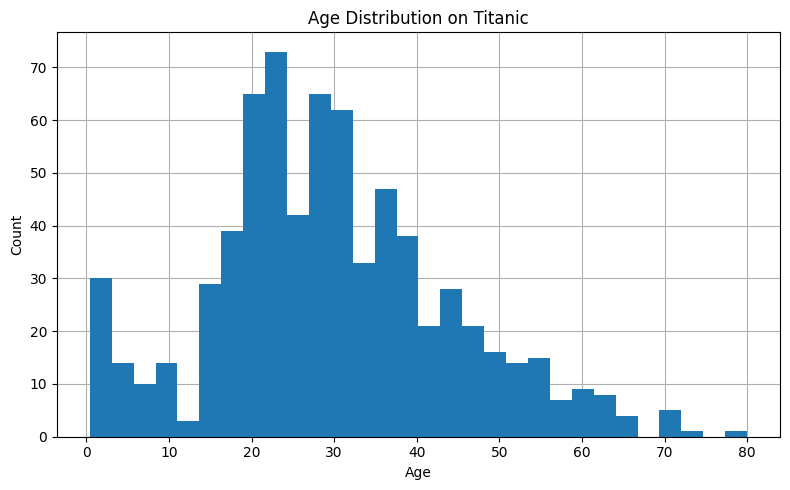

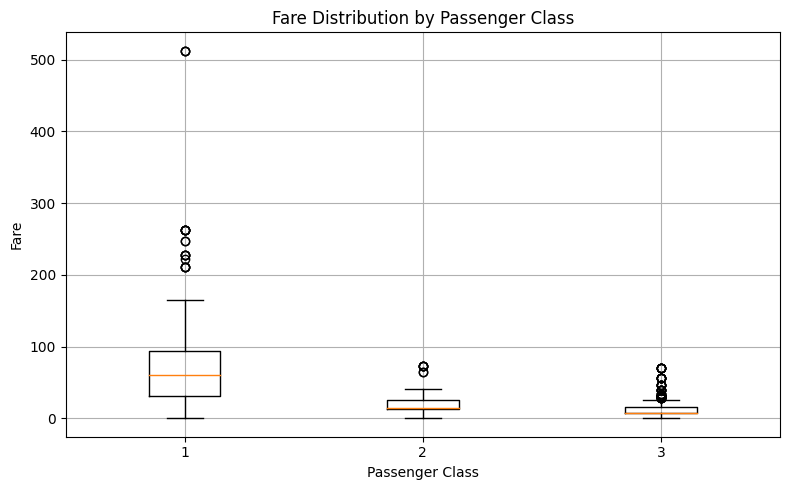

In [27]:
# train['Age'].hist(bins=30, figsize=(3,4)) 
# train.boxplot('Fare', by='Pclass', figsize=(3,4))
import matplotlib.pyplot as plt

# 1) Age histogram with grid behind
fig, ax = plt.subplots(figsize=(8, 5))
ax.set_axisbelow(True)            # draw grid below other artists
ax.hist(train['Age'].dropna(), bins=30, zorder=2)  
ax.grid(True, zorder=1)           # grid lines at zorder=1
ax.set_title('Age Distribution on Titanic')
ax.set_xlabel('Age')
ax.set_ylabel('Count')
fig.tight_layout()
plt.show()


# 2) Fare by Pclass boxplot with grid behind
fig, ax = plt.subplots(figsize=(8, 5))
ax.set_axisbelow(True)
groups = [train.loc[train['Pclass']==cls, 'Fare'].dropna()
          for cls in sorted(train['Pclass'].unique())]
ax.boxplot(groups, labels=sorted(train['Pclass'].unique()), zorder=2)
ax.grid(True, zorder=1)
ax.set_title('Fare Distribution by Passenger Class')
ax.set_xlabel('Passenger Class')
ax.set_ylabel('Fare')
fig.tight_layout()
plt.show()


# Define Features & Split

In [50]:
# NUM_COLS = ['Age','Fare']
# CAT_COLS = ['Sex','Embarked']
# TARGET   = 'Survived'

# # hold out a validation set
# X = train[NUM_COLS + CAT_COLS]
# y = train[TARGET]
# X_train, X_val, y_train, y_val = train_test_split(
#     X, y,
#     test_size=0.2,
#     random_state=42,
#     stratify=y
# )
# 0) imports
import pandas as pd

# 1) Extract the title in one shot using regex
pattern = r',\s*([^\.]+)\.'
for df in (train, test):
    df['Title'] = df['Name'].str.extract(pattern, expand=False)

# 2) Map rare titles into “Other”
common_titles = ['Mr', 'Miss', 'Mrs', 'Master']
for df in (train, test):
    df['Title'] = df['Title'].where(df['Title'].isin(common_titles), 'Other')

# 1.b) FamilySize & IsAlone
train['FamilySize'] = train['SibSp'] + train['Parch'] + 1
train['IsAlone']    = (train['FamilySize']==1).astype(int)

# 1.c) Deck
train['Deck'] = train['Cabin'].fillna('M').str[0]

# 1.d) FareBin (quartiles)
train['FareBin'] = pd.qcut(train['Fare'], 4, labels=False, duplicates='drop')

# 1.e) AgeBin
age_edges  = [0,12,20,40,60,80]
age_labels = ['Child','Teen','Adult','MidAge','Senior']
train['AgeBin'] = pd.cut(
    train['Age'].fillna(train['Age'].median()),
    bins=age_edges, labels=age_labels
)

# 2) =========================
#    Define updated feature lists
NUM_COLS = ['Age','Fare','FamilySize']
CAT_COLS = ['Pclass','Sex','Embarked',
            'Title','IsAlone','Deck','FareBin','AgeBin']
TARGET   = 'Survived'

# 3) =========================
#    Hold out validation set
X = train[NUM_COLS + CAT_COLS]
y = train[TARGET]

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

# 4) =========================
#    Build & fit your shared preprocessor
preprocessor = make_preprocessor(NUM_COLS, CAT_COLS)

# fit on train, transform both
X_train_proc = preprocessor.fit_transform(X_train)
X_val_proc   = preprocessor.transform(X_val)

# now X_train_proc / X_val_proc are ready for any model:
#   e.g. LogisticRegression().fit(X_train_proc, y_train)


# Engineer the new features

In [ ]:
# # 1. grab the title between “, ” and “. ”
# for df in (train, test):
#     df['Title'] = (
#         df['Name']
#           .str.split(',', expand=True)[1]
#           .str.split('.', expand=True)[0]
#           .str.strip()
#     )

# # 2. group rare titles under one category
# common_titles = ['Mr', 'Miss', 'Mrs', 'Master']
# for df in (train, test):
#     df['Title'] = df['Title'].where(df['Title'].isin(common_titles), 'Other')


# for df in (train, test):
#     df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
#     df['IsAlone']   = (df['FamilySize'] == 1).astype(int)

# for df in (train, test):
#     # take the first letter of Cabin; missing cab? mark “M”
#     df['Deck'] = df['Cabin'].fillna('M').str[0]

# # combine train+test to get consistent bins
# all_fare = pd.concat([train['Fare'], test['Fare']])
# fare_bins = pd.qcut(all_fare, 4, labels=False, duplicates='drop')

# # map back into each DF
# for df in (train, test):
#     df['FareBin'] = pd.qcut(df['Fare'], q=4, labels=False, duplicates='drop')

# # define your cut-points however you like
# age_edges = [0, 12, 20, 40, 60, 80]
# age_labels = ['Child','Teen','Adult','MidAge','Senior']

# for df in (train, test):
#     df['AgeBin'] = pd.cut(df['Age'].fillna(train['Age'].median()),
#                           bins=age_edges,
#                           labels=age_labels)

# NUM_COLS = ['Age','Fare','FamilySize']
# CAT_COLS = ['Pclass','Sex','Embarked','Title','IsAlone','Deck','FareBin','AgeBin']

# # After loading train/test:
# # 1) Title
# # 2) FamilySize & IsAlone
# # 3) Deck
# # 4) FareBin
# # 5) AgeBin

# # Then:
# feature_cols = NUM_COLS + CAT_COLS
# X_train = train[feature_cols];  y_train = train['Survived']
# # X_val   = X_val[feature_cols]; #y_val   = X_val['Survived']

# # train[NUM_COLS].corrwith(train['Survived'])
# # for c in CAT_COLS + ['Title', 'Deck']:
# #     print(pd.crosstab(train[c], train['Survived'], normalize='index'))


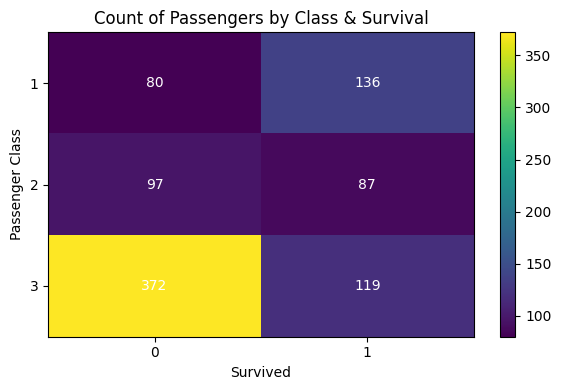

In [ ]:
# # 3B. Heatmap of raw counts (Pclass vs. Survived)
# counts = pd.crosstab(train['Pclass'], train['Survived'])

# fig, ax = plt.subplots(figsize=(6,4))
# ax.set_axisbelow(True)
# # imshow expects a 2D array
# im = ax.imshow(counts.values, aspect='auto', interpolation='nearest')
# # axis labels
# ax.set_xticks([0,1]);   ax.set_xticklabels(counts.columns)
# ax.set_yticks(counts.index - 1); ax.set_yticklabels(counts.index)
# ax.set_xlabel('Survived');    ax.set_ylabel('Passenger Class')
# ax.set_title('Count of Passengers by Class & Survival')
# ax.grid(False)               # grids can obscure the heatmap
# # annotate each cell with its count
# for i in range(counts.shape[0]):
#     for j in range(counts.shape[1]):
#         ax.text(j, i, counts.values[i,j], ha='center', va='center', color='white', zorder=3)
# # colorbar
# fig.colorbar(im, ax=ax)
# plt.tight_layout()
# plt.show()


# CAT COL heatmap

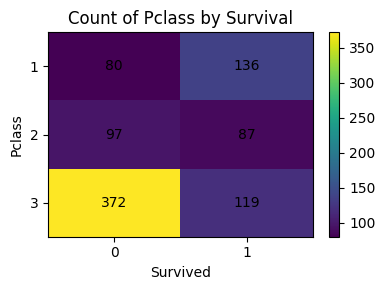

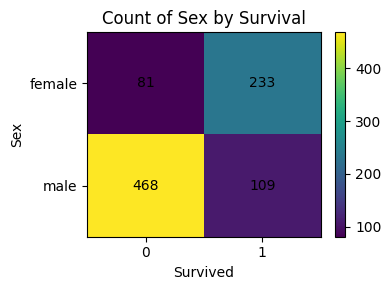

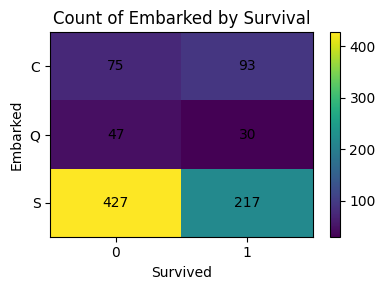

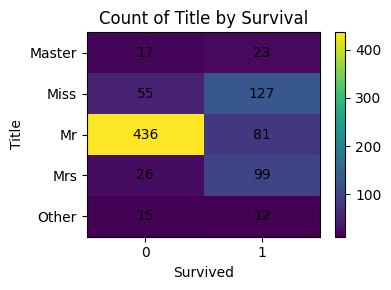

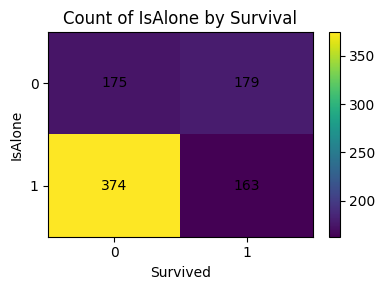

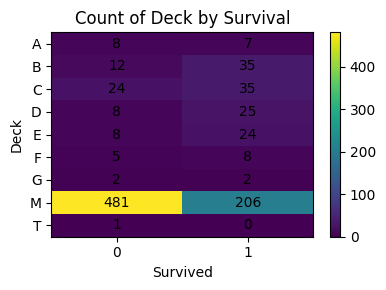

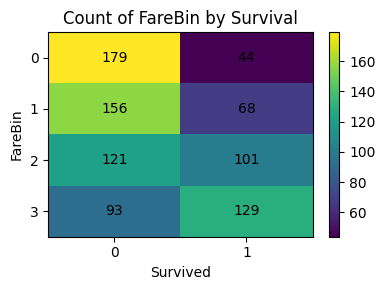

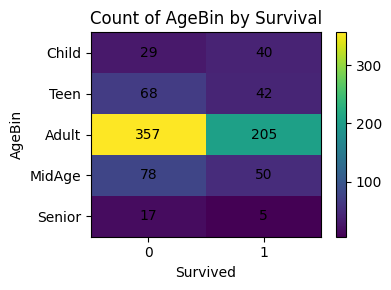

In [53]:
# 2. Loop & plot
for col in CAT_COLS:
    counts = pd.crosstab(train[col], train['Survived'])
    
    fig, ax = plt.subplots(figsize=(4, 3))
    ax.set_axisbelow(True)               # grid behind
    im = ax.imshow(counts.values, aspect='auto', interpolation='nearest')
    
    # ticks and labels
    ax.set_xticks(range(counts.shape[1]))
    ax.set_xticklabels(counts.columns)
    ax.set_yticks(range(len(counts.index)))
    ax.set_yticklabels(counts.index)
    ax.set_xlabel('Survived')
    ax.set_ylabel(col)
    ax.set_title(f'Count of {col} by Survival')
    
    # annotate cell values
    for i in range(counts.shape[0]):
        for j in range(counts.shape[1]):
            ax.text(j, i, counts.values[i, j], ha='center', va='center', zorder=3)
    
    fig.colorbar(im, ax=ax)
    plt.tight_layout()
    plt.show()


# PCA

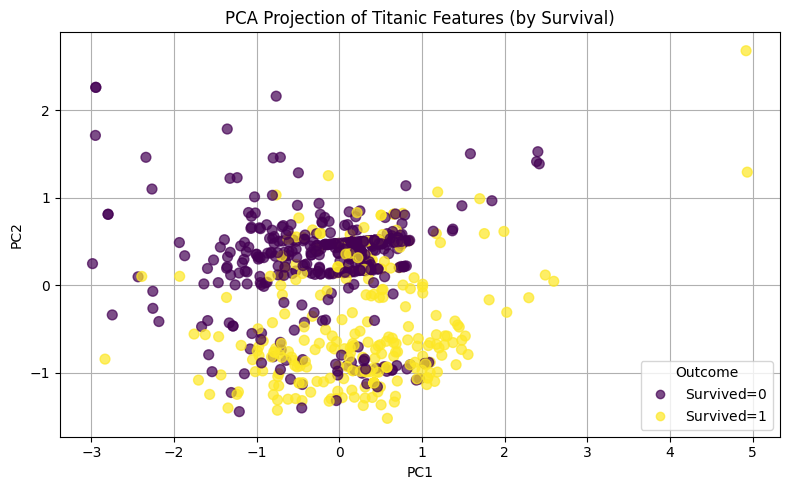

In [79]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# 1) Assuming you have your preprocessor and X_train_proc ready:
#    X_train_proc = preprocessor.fit_transform(X_train)
#    y_train       = y_train

# 2) Build a PCA pipeline (optional: you can combine preprocess + PCA in one)
pca_pipe = Pipeline([
    # ('preproc', preprocessor),       # your make_preprocessor(NUM_COLS, CAT_COLS)
    ('pca',     PCA(n_components=5, random_state=42))
])

# 3) Fit & transform
X_pca = pca_pipe.fit_transform(X_train_proc)

# 4) Plot the two principal components
fig, ax = plt.subplots(figsize=(8, 5))
ax.set_axisbelow(True)
scatter = ax.scatter(
    X_pca[:, 2],
    X_pca[:, 3],
    c=y_train,
    s=50,
    alpha=0.7,
    cmap='viridis'
)
ax.set_title('PCA Projection of Titanic Features (by Survival)')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')


handles, labels = scatter.legend_elements(
    prop="colors",
    alpha=0.7,
)
labels = [f"Survived={lab}" for lab in labels]

ax.legend(handles, labels, title="Outcome")
ax.grid(True)
plt.tight_layout()
plt.show()


In [82]:
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.model_selection import cross_val_score
union = FeatureUnion([
    ('orig', preprocessor),
    ('pca',  Pipeline([('preproc', preprocessor), ('pca', PCA(n_components=2))]))
])
pipe = Pipeline([('features', union),
                 ('clf', RandomForestClassifier())])
scores = cross_val_score(pipe, X_train, y_train, cv=5)
print("Fold scores:", scores)
print("Mean accuracy: %.3f ± %.3f" % (scores.mean(), scores.std()))


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Fold scores: [0.79020979 0.74125874 0.83802817 0.82394366 0.81690141]
Mean accuracy: 0.802 ± 0.034


# t-SNE

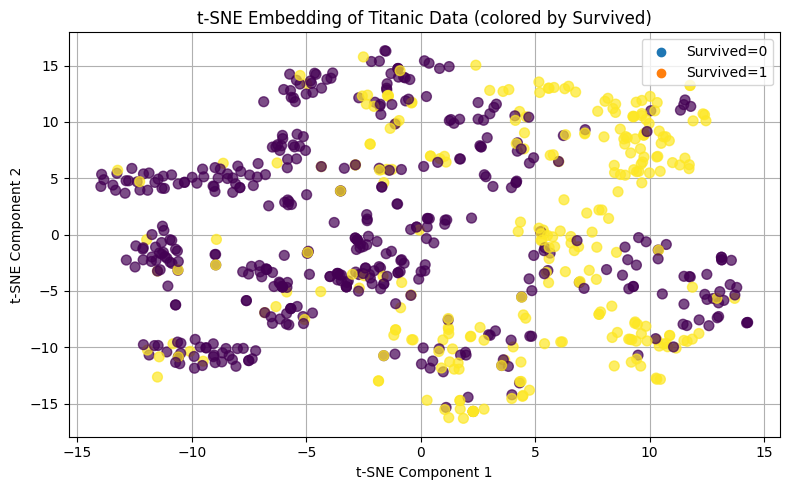

In [62]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3, random_state=42)
X_tsne = tsne.fit_transform(X_train_proc)

fig, ax = plt.subplots(figsize=(8, 5))
ax.set_axisbelow(True)
scatter = ax.scatter(
    X_tsne[:, 0],
    X_tsne[:, 1],
    c=y_train,
    s=50,
    alpha=0.7,cmap='viridis'
)
ax.set_title('t-SNE Embedding of Titanic Data (colored by Survived)')
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')

# Build legend manually
for label in sorted(y_train.unique()):
    ax.scatter([], [], label=f'Survived={label}')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()


# Baseline Model Comparison

In [16]:
preproc = make_preprocessor(NUM_COLS, CAT_COLS)

model_defs = {
    'LogisticRegression': {
        'preproc': preproc,
        'clf': LogisticRegression(max_iter=1000)
    },
    'RandomForest': {
        'preproc': preproc,
        'clf': RandomForestClassifier(n_jobs=-1)
    },
    'GradientBoosting': {
        'preproc': preproc,
        'clf': GradientBoostingClassifier()
    },
    'SVM': {
        'preproc': preproc,
        'clf': SVC()
    },
}

baseline_scores = compare_models(model_defs, X_train, y_train)
baseline_scores


SVM                   0.796405
GradientBoosting      0.789402
LogisticRegression    0.783768
RandomForest          0.779612
dtype: float64

In [19]:
from common.pipelines     import compare_models
from common.preprocessing import make_preprocessor


# Hyperparameter tuning

In [21]:
# example: tune RandomForest
rf_pipe = Pipeline([('preproc', preproc), ('clf', RandomForestClassifier())])
rf_grid = {
    'clf__n_estimators': [100,200,300],
    'clf__max_depth':    [None,5,10],
}
rf_search = grid_search(rf_pipe, rf_grid, X_train, y_train)
print(rf_search.best_params_, rf_search.best_score_)


Fitting 5 folds for each of 9 candidates, totalling 45 fits


{'clf__max_depth': 5, 'clf__n_estimators': 200} 0.7978233034571064


# Validate & Report

In [22]:
best_model = rf_search.best_estimator_
val_preds = best_model.predict(X_val)
print("Val Accuracy:", accuracy_score(y_val, val_preds))
print(classification_report(y_val, val_preds))


Val Accuracy: 0.776536312849162
              precision    recall  f1-score   support

           0       0.80      0.85      0.82       110
           1       0.74      0.65      0.69        69

    accuracy                           0.78       179
   macro avg       0.77      0.75      0.76       179
weighted avg       0.77      0.78      0.77       179



# Final Fit & Submission

In [23]:
# retrain on full training data
best_model.fit(train[NUM_COLS + CAT_COLS], train[TARGET])

# predict test set
submission = pd.DataFrame({
    'PassengerId': test['PassengerId'],
    'Survived':    best_model.predict(test[NUM_COLS + CAT_COLS])
})
submission.to_csv('submission.csv', index=False)
